<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_5%5DClassifying_by_rock%2C_paper%2C_scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_5]Classifying by rock, paper, scissor

## 1. import하기

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import glob
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## 2.함수 만들기

### 1) 이미지 사이즈 변환
- 28X28 사이즈로 변경을 할 것이다.



In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

### 2) load data

In [3]:
def load_data(img_path, number_of_data):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

## 3. 이미지 사이즈 변환하기

In [4]:
# train_scissor
train_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/scissor"
resize_images(train_scissor_image_dir_path)

# train_rock
train_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/rock"
resize_images(train_rock_image_dir_path)

# train_paper
train_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/paper"
resize_images(train_paper_image_dir_path)

# test_scissor
test_scissor_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/scissor"
resize_images(test_scissor_image_dir_path)

# test_rock
test_rock_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/rock"
resize_images(test_rock_image_dir_path)

# test_paper
test_paper_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test/paper"
resize_images(test_paper_image_dir_path)

650  images to be resized.
650  images resized.
650  images to be resized.
650  images resized.
650  images to be resized.
650  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## 4. train, test 데이터셋 불러오기 및 정규화
- 픽셀값은 0-255 사이의 값을 가진다. 인공지능 모델을 훈련시킬때 0-1사이로 정규화해주는 것이 더 높은 성능을 얻을 수 있다. 

### 1) train

In [5]:
train_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper"
(x_train, y_train)=load_data(train_image_dir_path,number_of_data=1950)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 1950 입니다.


In [6]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (1950, 28, 28, 3)
y_train shape: (1950,)


### 2) test

In [7]:
test_image_dir_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/rock_scissor_paper/test"
(x_test, y_test)=load_data(test_image_dir_path,number_of_data=300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [8]:
print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 5. 딥러닝 네트워크 설계

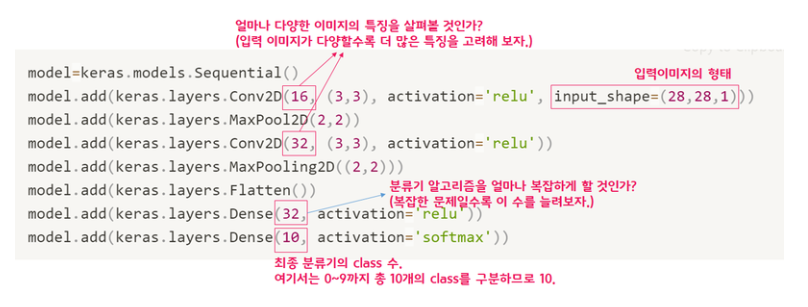

- Conv2D는 레이어의 첫번째 인자는 사용하는 이미지의 특징의 수이다. 정확도를 올리기 위해 손글씨보다 더 많은 특징의 수를 고려하 예정이다.
- input_shape는 손글씨와 다른 점이 마지막 숫자로 손글씨는 흑백으로 1을 설정하였지만 가위, 바위, 보는 모든 색을 나타내기 때문에 RGB 모두를 표현한 3을 기입하였다.
- Dense의 첫번째 인자는 분류기에 사용되는 뉴런의 숫자로 이 값이 클수록 보다 복잡한 분류기를 만들수 있다. 이 또한 정확도를 올리기 위해 손글찌보다 높은 숫자를 사용할 예정이다.
- 마지막 Dense 레이어의 뉴런 숫자는 분류해 내야 하는 클래수의 수로 손글씨와는 다르게 가위, 바위, 보로 클래스가 3개로 이루어져있어 3을 기입할 예정이다.
- https://keras.io/ko/getting-started/sequential-model-guide/ -> 해당 링크로 추가적인 공부를 할 수 있다.

In [9]:

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (N

## 6. 딥러닝 학습 및 검증

### 1) 모델 학습

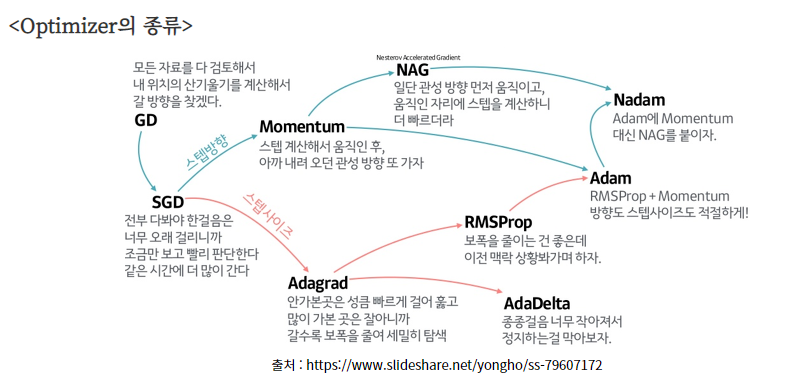

- 우리가 사용할 optimizer는 adam이다. 이는 RMSProp + Momentum방향도 스텝사이즈도 적절하게 한다는 뜻이다. 보다 구체적인 설명은 해당 링크로 가면 확인할 수 있다. -> https://ganghee-lee.tistory.com/24

- 우리가 사용할 loss는 "sparse_categorical_crossentropy"로 다중분류손실함수로 integer type 클래스를 one-hot encoding하지 않고 정수형태로 lable을 넣어주는 것으로 한 샘플에 여러 클래스가 있거나 label이 soft확률일 경우 사용한다.  다른 loss 함수를 알고 싶다면 해당 링크로 가면 된다. -> https://hororolol.tistory.com/375

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
             
history = model.fit(x_train, y_train,validation_split=0.25, epochs=9)

Epoch 1/9
46/46 [==============================] - 3s 45ms/step - loss: 3.4168 - accuracy: 0.5814 - val_loss: 1.4791 - val_accuracy: 0.1537
Epoch 2/9
46/46 [==============================] - 2s 40ms/step - loss: 0.4384 - accuracy: 0.8358 - val_loss: 3.5680 - val_accuracy: 0.0738
Epoch 3/9
46/46 [==============================] - 2s 41ms/step - loss: 0.2148 - accuracy: 0.9350 - val_loss: 2.4851 - val_accuracy: 0.1783
Epoch 4/9
46/46 [==============================] - 2s 41ms/step - loss: 0.1292 - accuracy: 0.9685 - val_loss: 4.2357 - val_accuracy: 0.1209
Epoch 5/9
46/46 [==============================] - 2s 40ms/step - loss: 0.0926 - accuracy: 0.9754 - val_loss: 3.2336 - val_accuracy: 0.1885
Epoch 6/9
46/46 [==============================] - 2s 41ms/step - loss: 0.0700 - accuracy: 0.9815 - val_loss: 2.8032 - val_accuracy: 0.1967
Epoch 7/9
46/46 [==============================] - 2s 42ms/step - loss: 0.0553 - accuracy: 0.9863 - val_loss: 2.7902 - val_accuracy: 0.2418
Epoch 8/9
46/46 [===

- 해당 코드는 기존의 LMS 코드와 다른 점을 확인할 수 있는데 model fit한 것을 history에 넣었다는 것과 validation_split를 지정하였다는 것이다.
- history에 넣은 이유는 추후 그래프를 그리기 위함이다.
- validation은 이미 완료된 모델을 검증하기 위한 dataset이며 학습과 검증이 완료된 모델의 성능을 평가하기 위하여 추후 test 셋으로 평가를 할 것이다. 자세한 내용은 해당 링크를 통해 확인할 수 있다. 
  - -> https://ganghee-lee.tistory.com/38,                            
  - -> https://davincilabs.ai/blog/?q=YToxOntzOjEyOiJrZXl3b3JkX3R5cGUiO3M6MzoiYWxsIjt9&bmode=view&idx=10640969&t=board

### 2) 모델 검증

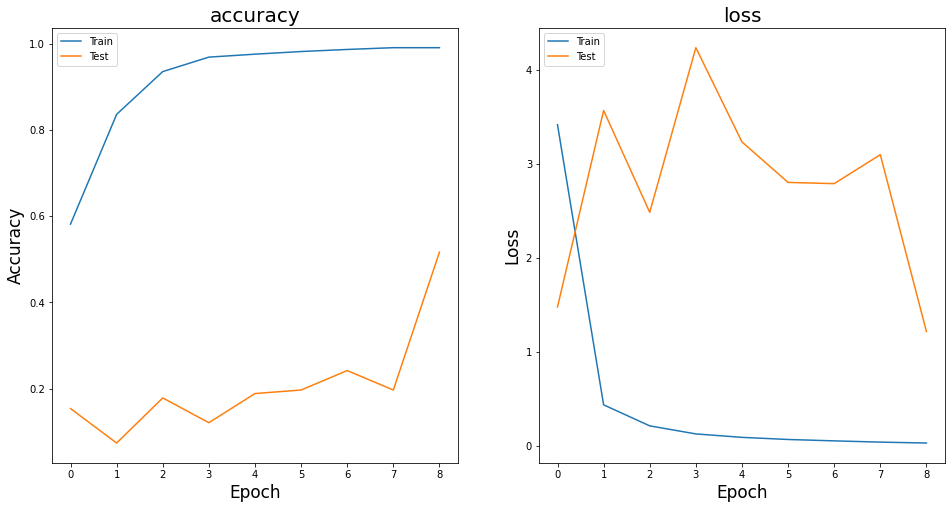

In [11]:
f, ax = plt.subplots(1,2,figsize=(16,8))


ax[0].plot(history.history['accuracy'] )
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('accuracy',fontsize=20)
ax[0].set_xlabel('Epoch',fontsize=17)
ax[0].set_ylabel('Accuracy',fontsize=17)
ax[0].legend(['Train', 'Test'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('loss',fontsize=20)
ax[1].set_xlabel('Epoch', fontsize=17)
ax[1].set_ylabel('Loss',fontsize=17)
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

## 6. 평가지표 및 정확도, loss 확인

In [12]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

- 모델이 추론한 확률 값 및 배열에서 가장 높은 값을 가진 인덱스 값 반환

In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))
print("\n",classification_report(y_test,predicted_labels))

10/10 - 0s - loss: 0.6849 - accuracy: 0.7667 - 120ms/epoch - 12ms/step
test_loss: 0.6849307417869568 
test_accuracy: 0.7666666507720947

               precision    recall  f1-score   support

           0       0.64      0.89      0.74       100
           1       0.91      0.95      0.93       100
           2       0.81      0.46      0.59       100

    accuracy                           0.77       300
   macro avg       0.79      0.77      0.75       300
weighted avg       0.79      0.77      0.75       300



- model.evaluate 사용 : 케라스의 함수로 모델의 저확도를 평가할 수 있는 기능을 제공한다. 자세한 내용은 해당 링크로 -> https://thebook.io/080244/part04/unit16/07/

## 7. 어떤 데이터를 잘못 추론 했는지 확인

model.predict() 결과 :  [0.98830646 0.00210542 0.00958809]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


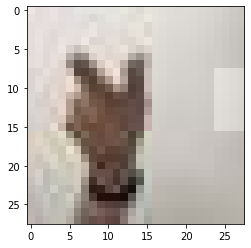

In [14]:
idx=0
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

예측확률분포: [0.5856558  0.01303325 0.4013109 ]
라벨: 2, 예측결과: 0


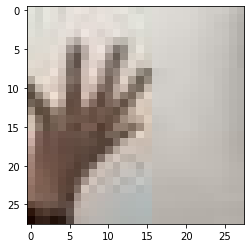

예측확률분포: [0.8205663  0.00369255 0.17574121]
라벨: 2, 예측결과: 0


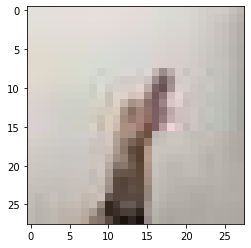

예측확률분포: [9.4477391e-01 1.8585037e-04 5.5040222e-02]
라벨: 2, 예측결과: 0


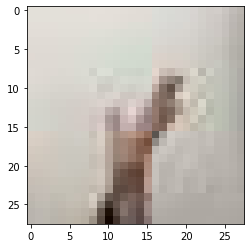

예측확률분포: [0.14955819 0.680682   0.16975984]
라벨: 2, 예측결과: 1


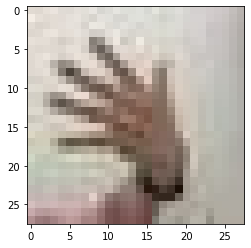

예측확률분포: [9.9598795e-01 3.5713937e-03 4.4059145e-04]
라벨: 1, 예측결과: 0


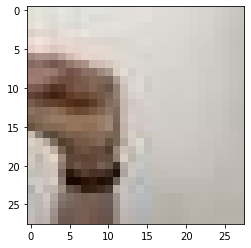

In [15]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## 8. 회고

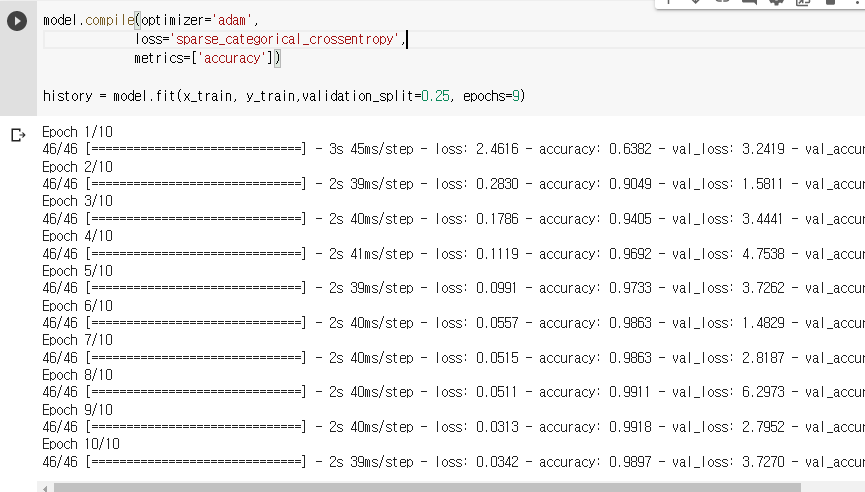